<a href="https://colab.research.google.com/github/tinghe14/COURSE-2Deep-Learning/blob/main/DL_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Programming

The following notebook contains skeleton-code for answering problems 2 and 3 of homework assignment 2. Please read through each cell carefully to understand what is expected to be implemented. For your final submission, please try to clean up any intermediate outputs used for debugging.

### Imports

You should be able to complete the entire assignment using only the following imports. Please consult the course staff if you are unsure about whether additional packages may be used.

In [ ]:
## Import Packages
import random
import numpy as np
import matplotlib.pyplot as plt

## Question 2


Below we provide an AutoGrad class named `Value`. The basic idea is to store the existing computational map during the creation of each `Value`, and calculate the gradient using backpropagation when one of the `Value` calls `backward()` method.

The `backward()` function will arange the computational graph and backpropagate the gradients. All you need to do is to implement all the operations with its corresponding `_backward` function. We have provided the `__add__` function (sum of two nodes) as an example to help get you started.

This notebook is designed in a Object Oriented way, if you are not farmiliar with the Object Oriented Programming in Python, you can refer to:

(1) https://realpython.com/python3-object-oriented-programming/

(2) https://docs.python.org/3/tutorial/classes.html


In [ ]:
from collections import defaultdict, deque #double-ended queue

class Value:
    
    """
    Basic unit of storing a single scalar value and its gradient
    """
    
    def __init__(self, data, _children=()):
        """
        
        """
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._backward = lambda: None
    
    def __add__(self, other):
        """
        Example implementation of a single class operation (addition)
        
        Args:
            other (Any): Node to add with the class
        
        Returns:
            out (callable): Function to referesh the gradient
        """
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        #Secondly, create a new Value object which is the result of the operation 
        out = Value(self.data + other.data, (self, other))

        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens, 
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation (e.g. Value(3) * Value(2) = Value(6))
        """
        #TODO implement multiplication operation
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other))

        def _backward():
          self.grad += out.grad * other.data
          other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        """
        Power operation (e.g Value(3) ** 2 = Value(9))
        """
        #TODO implement power operation, we don't need to convert the exponent to Value
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,)) # other(exponent) not a node

        def _backward():
          self.grad += out.grad * other * self.data ** (other - 1)  
        out._backward = _backward
        return out
    
    def relu(self):
        """
        ReLU activation function applied to the current Value
        """
        #TODO implement the relu activation function for the value itself.
        out = Value(max(0, self.data), (self,))
        def _backward():
          if self.data <= 0:
            self.grad += 0
          else:
            self.grad += 1 * out.grad  
        out._backward = _backward  
        return out
    
    
    def exp(self):
        """
        Exponentiate the current Value (e.g. e ^ Value(0) = Value(1))
        """
        #TODO implement the exponential function for and treat the value as exponent.
        #The base is natural e, you can use numpy to calculate the value of the exponential.
        out = Value(np.e ** self.data, (self,))
        def _backward():
          self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    def log(self):
        """
        Take the natural logarithm (base e) of the current Value
        """
        #TODO implement the logarithm function for and treat the value as exponent.
        #The bottom number should be e, you can use numpy to calculate the value of the logarithm.
        out = Value(np.log(self.data), (self,))
        def _backward():
          self.grad += out.grad / self.data
        out._backward = _backward
        return out
    
    def backward(self):
        """
        Run backpropagation from the current Value
        """
        #This function is called when you start backpropagation from this Value

        #The gradient of this value is initialized to 1 for you.
        self.grad = 1

        #You need to find a right topological order all of the children in the graph.
        #As for topology sort, you can refer to http://www.cs.cornell.edu/courses/cs312/2004fa/lectures/lecture15.htm

        #caculate num of _parent for each node
        topo = [] # sorted nodes
        num_child = defaultdict(int)
        stack = [self]
        while stack:
          cur = stack.pop()
          for node in cur._prev:
            if node not in num_child:
              stack.append(node)
            num_child[node] += 1

        queue = deque([self])
        while queue:
          cur = queue.popleft() #FIFO
          topo.append(cur)
          for node in cur._prev:
            if num_child[node] == 1:
              queue.append(node)
            else:
              num_child[node] -= 1 
        #TODO find the right list of Value to be traversed
        '''
        Hint: you can recursively visit all non-visited node from the node calling backward.
        add one node to the head of the list after all of its children node are visited
        '''

        #go one variable at a time and apply the chain rule to get its gradient

        for v in topo:
            v._backward()

    # We handled the negation and reverse operations for you
    def __neg__(self): # -self
        """
        Negate the current Value
        """
        return self * -1

    def __radd__(self, other): #other + self
        """
        Reverse addition operation (ordering matters in Python)
        """
        return self + other
    
    def __sub__(self, other): # self - other
        """
        Subtraction operation
        """
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        """
        Reverse subtraction operation
        """
        return other + (-self)
    
    def __rmul__(self, other): # other * self
        """
        Reverse multiplication operation
        """
        return self * other
    
    def __truediv__(self, other): # self / other
        """
        Division operation
        """
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        """
        Reverse diction operation
        """
        return other * self**-1
    
    def __repr__(self): #print methof
        """
        Class representation (instead of unfriendly memory address)
        """
        return f"Value(data={self.data}, grad={self.grad})"

Now, we are going to use the simple example in q1.b to get you familar with the usage of this class.

If your implementation is correct, you will get the same values and gradients as your hand-caculated ones.

Be careful! Even you get this test case right, it does not guarantee the correctness of your implementation. 

In [ ]:
## Initialize Example Values (From Written Assignment)
w1 = Value(0.3)
w2 = Value(-0.5)
x1 = Value(0.2)
x2 = Value(0.4)

#TODO
#Do calculation for the question 1.b, and call backward to start backpropagation.
#Then print out the gradient of w1 w2 x1 x2.
f = 1 / (1 + (-w1 * x1 - w2 * x2).exp()) + 0.5 * w1**2 + 0.5 * w2**2
f.backward()

w1, w2, x1, x2

(Value(data=0.3, grad=0.34975579811673396),
 Value(data=-0.5, grad=-0.400488403766532),
 Value(data=0.2, grad=0.074633697175101),
 Value(data=0.4, grad=-0.124389495291835))

In [ ]:
# intermediate values
# forward
print("Intermediate (value) results for forward process: ")
k= (w1 * x1).data
print(f"node K = {k}")
l = (w2 * x2).data
print(f"node L ={l}")
f = (w1 * x1 + w2 * x2).data
print(f"node F ={f}")
e = (-w1 * x1 - w2 * x2).data
print(f"node E ={e}")
d = ((-w1 * x1 - w2 * x2).exp()).data
print(f"node D ={d}")
c = (1 + (-w1 * x1 - w2 * x2).exp()).data
print(f"node C ={c}")
b = (1/(1 + (-w1 * x1 - w2 * x2).exp())).data
print(f"node B ={b}")
h = (w1**2).data
print(f"node H ={h}")
g = (0.5 * w1**2).data
print(f"node G ={g}")
j = (w2**2).data
print(f"node J ={j}")
i = (0.5 * w2**2).data
print(f"node I ={i}")
a = (1/(1 + (-w1 * x1 - w2 * x2).exp()) + 0.5 * w1**2 + 0.5 * w2**2).data
print(f"node A  ={a}")

Intermediate (value) results for forward process: 
node K = 0.06
node L =-0.2
node F =-0.14
node E =0.14
node D =1.1502737988572274
node C =2.1502737988572274
node B =0.4650570548417855
node H =0.09
node G =0.045
node J =0.25
node I =0.125
node A  =0.6350570548417855


In [ ]:
# backward
m = 0.3
n = 0.2
o = 0.4
p = -0.5
print("Intermediate (gradient) results for backward process: ")
gb = Value(g)
ab = Value(a)
ib = Value(i)
fx = ab + gb +ib
fx.backward()
print(f"node A = {ab.grad}")
cb = Value(c)
fx = 1/cb
fx.backward()
print(f"node B = {cb.grad * ab.grad}")
db = Value(d)
fx = db + 1
fx.backward()
print(f"node C = {db.grad * cb.grad * ab.grad}")
eb = Value(e)
fx = eb.exp()
fx.backward()
print(f"node D = {eb.grad * db.grad * cb.grad * ab.grad}")
fb = Value(f)
fx = fb * (-1)
fx.backward()
print(f"node E = {fb.grad * eb.grad * db.grad * cb.grad * ab.grad}")
kb = Value(k)
lb = Value(l)
fx = kb + lb
fx.backward()
print(f"node F = {kb.grad * fb.grad * eb.grad * db.grad * cb.grad * ab.grad}")
hb = Value(h)
fx = hb * 0.5
fx.backward()
print(f"node G = {hb.grad * ab.grad}")
mb = Value(m)
fx = mb**2
fx.backward()
nodeh = mb.grad * hb.grad * ab.grad
print(f"node H = {nodeh}")
nb = Value(n)
fx = mb * nb
fx.backward()
print(f"node N - K = {nb.grad * kb.grad * fb.grad * eb.grad * db.grad * cb.grad * ab.grad}")
ob = Value(o)
pb = Value(p)
fx = ob * pb
fx.backward()
print(f"node O - L = {ob.grad * kb.grad * fb.grad * eb.grad * db.grad * cb.grad * ab.grad}")
jb = Value(j)
fx = jb * 0.5
fx.backward()
print(f"node I = {jb.grad * ab.grad}")
pb = Value(p)
fx = pb**2
fx.backward()
nodej = pb.grad * jb.grad * ab.grad
print(f"node J = {nodej}")
mb = Value(m)
fx = mb * nb
fx.backward()
nodem_k = mb.grad * kb.grad * fb.grad * eb.grad * db.grad * cb.grad * ab.grad
print(f"node M - K = {nodem_k}")
print(f"node M = node M - K + node H = {nodem_k + nodeh}")
pb = Value(p)
fx = pb * ob
fx.backward()
nodep_l =  pb.grad * kb.grad * fb.grad * eb.grad * db.grad * cb.grad * ab.grad
print(f"node P - L = {nodep_l }")
print(f"node P = node P - L + node J = {nodep_l + nodej}")

Intermediate (gradient) results for backward process: 
node A = 1
node B = -0.21627806425811547
node C = -0.21627806425811547
node D = -0.24877899058367
node E = 0.24877899058367
node F = 0.24877899058367
node G = 0.5
node H = 0.3
node N - K = 0.074633697175101
node O - L = -0.124389495291835
node I = 0.5
node J = -0.5
node M - K = 0.049755798116734
node M = node M - K + node H = 0.34975579811673396
node P - L = 0.099511596233468
node P = node P - L + node J = -0.400488403766532


## Question 3

### Implementation of the linear layer
You will implement a `LinearLayer` module here.

We provide the initialization of the class `LinearLayer`. You need to implement the forward function -- Return the results - `out` with the shape `[n_samples, n_out_channels]` of a linear layer when the the data `x` shaped `[n_samples, n_in_channels]` is fed into it.
 

In [ ]:
svpath = './Q3_data.npz'
data = np.load(svpath)

# X, array of shape [n_samples, n_features]
# Y, array of shape [n_samples]
X = data['X']
Y = data['Y']
print(X.shape, Y.shape)

(100, 2) (100,)


In [ ]:
class Module:
    
    """
    Base Model Module
    """
    
    def parameters(self):
        """
        
        """
        return []

    def zero_grad(self):
        """
        
        """
        for p in self.parameters():
            p.grad = 0

class LinearLayer(Module):
    
    """
    Linear Layer
    """
    
    def __init__(self, nin, nout):
        """
        Here we randomly initilize the weights w as 2-dimensional list of Values
        And b as 1-dimensional list of Values with value 0
        
        You may use this stucture to implement the __call__ function

        @param:
        nout = num of rows
        nin = num of cols
        """
        self.w = []
        for i in range(nin):
            w_tmp = [Value(random.uniform(-1,1)) for j in range(nout)]
            self.w.append(w_tmp)
        self.b = [Value(0) for i in range(nout)]
        self.nin = nin
        self.nout = nout
  
    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]
            w:[nin, nout]
        
        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout] 
        """
        #TODO implement this function and return the output of a linear layer.
        #return NotImplementedError
        batch_size = len(x[0])
        xout = []
        for i in range(self.nout):
          xout_temp = [Value(0) for j in range(batch_size)]
          xout.append(xout_temp)
        xout = np.dot(x, self.w) + self.b
        return xout
  
    def parameters(self):
        """
        Get the list of parameters in the Linear Layer
        
        Args:
            None
        
        Returns:
            params (list): List of parameters in the layer
        """
        return [p for row in self.w for p in row] + [p for p in self.b]

Test your implementation of linear layer, the error should be nearly 0.

In [ ]:
## Initialization of Layer with Weights
linear_model_test = LinearLayer(4, 4)
linear_model_test.w = [[Value(data=0.7433570245252463), Value(data=-0.9662164096144394), Value(data=-0.17087204941322653), Value(data=-0.5186656374983067)], 
                       [Value(data=-0.1414882837892344), Value(data=-0.5898971049017006), Value(data=-0.3448340220492381), Value(data=0.5278833226346107)], 
                       [Value(data=0.3990701306597799), Value(data=-0.3319058654296163), Value(data=-0.784797384411202), Value(data=0.7603317495966846)], 
                       [Value(data=-0.5711035064293541), Value(data=-0.0001937643033362857), Value(data=0.12693226232877053), Value(data=-0.36044237239197097)]]
linear_model_test.b = [Value(data=0), Value(data=0), Value(data=0), Value(data=0)]

## Forward Pass
x_test = [[-0.17120438454836173, -0.3736077734087335, -0.48495413054653214, 0.8269206715993096]]
y_hat_test = linear_model_test(x_test)
y_ref = [[Value(data=-0.7401928625441141), Value(data=0.5466095223360173), Value(data=0.6436403600545564), Value(data=-0.7752067527386406)]]

## Error Calculation
predict_error = 0
for i in range(4):
    predict_error += (y_hat_test[0][i] - y_ref[0][i])**2
print(predict_error.data)

0.0


In [ ]:
linear_model_test.nin #4
linear_model_test.nout #4

4

### Implementation of Loss functions

You will implement softmax, cross entropy loss, and accuracy here for further use

In [ ]:
def logsumexp(x):
  """compute log sum_i exp(x_i)"""
  xmax = max(v.data for v in x)
  return np.log(np.sum(np.exp([v - xmax for v in x]))) + xmax

def softmax(y_hat):
    """
    Softmax computation
    
    Args:
        y_hat (2d-list): 2-dimensional list of Values with shape [batch_size, n_class]
    
    Returns:
        s (2d-list): 2-dimensional list of Values with the same shape as y_hat   
    """
    #TODO implement the softmax function and return the output.
    # exp first then norm them
    y_hat = np.array(y_hat)
    # exp_y_hat = np.exp(y_hat)
    # return exp_y_hat / exp_y_hat.sum(axis = 1).reshape(-1, 1)
    return np.exp(y_hat - np.array([logsumexp(row) for row in y_hat]).reshape(-1, 1))

In [ ]:
def cross_entropy_loss(y_hat, y):
    """
    Cross-entropy Loss computation
    
    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ]
    
    Returns:
        loss (Value): Loss value of type Value
    """
    #TODO implement the calculation of cross_entropy_loss between y_hat and y.
    s = softmax(y_hat)
    batch_size = s.shape[0]
    loss = 0
    for i in range(batch_size):
      key_i = s[i, y[i]]
      loss += key_i.log() * (-1)
    return loss

In [ ]:
def accuracy(y_hat, y):
    """
    Accuracy computation
    
    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ]
    
    Returns:
        acc (float): Accuracy score
    """
    #TODO implement the calculation of accuracy of the predicted y_hat w.r.t y.
    batch_size = len(y_hat)
    y_pred = np.zeros(batch_size)
    for i in range(batch_size):
      max_data = y_hat[i][0].data
      max_index = 0
      for j in range(len(y_hat[i])): 
        if y_hat[i][j].data > max_data:
          max_data = y_hat[i][j].data
          max_index = j
      y_pred[i] = max_index
    return np.mean(y_pred == y)

Test the implementation of `softmax()` and `cross_entropy_loss()` as well as the gradient calculation of `Value` class. The errors should be nearly 0.

In [ ]:
## Ground Truth + Forward Pass
y_gt = [1]
y_hat_test = linear_model_test(x_test)

## Softmax Calculation
prob_test = softmax(y_hat_test)
prob_ref = [[0.10441739448437284, 0.37811510516540814, 0.4166428991676558, 0.10082460118256342]]
softmax_error = 0
for i in range(4):
    softmax_error += (prob_ref[0][i] - prob_test[0][i])**2
print(softmax_error.data)

## Cross Entropy Loss Calculation
loss_test = cross_entropy_loss(y_hat_test, y_gt)
loss_ref = Value(data=0.9725566186970217)
print((loss_test - loss_ref).data)

## Update Gradient Based on Loss
linear_model_test.zero_grad()
loss_test.backward()
w_gradient_ref = [[-0.017876715758840547, 0.10646942068007896, -0.07133109112844363, -0.01726161379279479], 
                  [-0.0390111502584479, 0.23234103087567629, -0.1556610258645873, -0.03766885475264107], 
                  [-0.05063764675610328, 0.30158564847453107, -0.2020526949142369, -0.04889530680419089], 
                  [0.08634490197366762, -0.5142494748940867, 0.3445306259968013, 0.08337394692361787]]
b_gradient_ref = [0.10441739448437282, -0.6218848948345919, 0.4166428991676557, 0.1008246011825634]

## Compute Error
w_gradient_error = 0
b_gradient_error = 0
for i in range(4):
    b_gradient_error += (linear_model_test.b[i].grad - b_gradient_ref[i]) ** 2
    for j in range(4):
        w_gradient_error += (linear_model_test.w[i][j].grad - w_gradient_ref[i][j]) ** 2
print(w_gradient_error)
print(b_gradient_error)

7.125940794232773e-33
1.1102230246251565e-16
1.6851887013388314e-32
1.3096323621833204e-32


Implement the following functions to visualize the ground truth and the decision boundary in the same figure.

In [ ]:
def plot_points(X, Y, scale, n, data):
    """
    Plot points in the visualization image
    """
    points_color = [[0., 0. , 255.], [255., 0., 0.], [0., 255., 0.],[0., 0. , 0.]]
    
    for i in range(X.shape[0]):
        #TODO Assign a color to "data" according to the position and the label of X
        x_ind = int((X[i, 0] + scale) * n / (2 * scale))
        y_ind = int((X[i, 1] + scale) * n / (2 * scale))
        data[x_ind, y_ind, :] = points_color[int(Y[i])] 
    return data


def plot_background(scale, n, model):
    """
    Color the background in the visualization image
    """

    background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]
   
    data = np.zeros((n,n,3), dtype='uint8')
    
    for i in range(n):
        x1 = -scale + 2 * scale / n * i
        for j in range(n):
            x2 = -scale + 2 * scale / n * j
            input = [[Value(x1),Value(x2)]]
            #TODO using the model to predict a class for the input and assign a color to "data" at this position.
            scores = [x.data for x in model(input)[0]]
            pred = np.argmax(scores)
            data[i, j, :] = background_color[pred]
    return data


def visualization(X, Y, model):
    """
    Decision boundary visualization
    """
    scale = 4.5  # the scale of X axis and Y axis. To say, x is from -scale to +scale
    n = 300      # seperate the image into n*n pixels 

    data = plot_background (scale, n, model)
    data = plot_points (X, Y, scale, n, data)
    
    plt.imshow(data)
    plt.axis('off')
    plt.show()

if you implement the plot function correctly, you will get some image like:

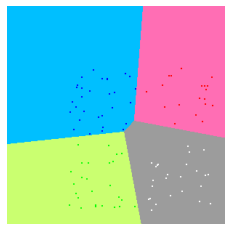


### Implementation of training procedure

With input data `x`, ground_truth `y`, and `model` as parameters, implement the gradient descent method to train your model and plot loss and accuracy vs training iterations

In [ ]:
def train(x,
          y,
          model,
          loss_function=cross_entropy_loss, 
          accuracy_function=accuracy,
          max_iteration=500,
          learning_rate=1):
    """
    Args:
       x (2-d list): List of Values with shape: [n_samples, n_channels]
       y (1-d list): List of integers with shape: [n_samples]
       model (Module): Linear model
       loss_function (callable): Loss function to use during training
       accuracy_function (callable): Function used for calculating training accuracy
       max_iteration (int): Number of epochs to train model for
       learning_rate (numeric): Step size of the gradient update
    """
    for i in range(max_iteration):
        #TODO compute y_hat and calculate the loss between y_hat and y as well as
        # the accuracy of y_hat w.r.t y.
        y_hat = model(x)
        loss = cross_entropy_loss(y_hat, y)
        acc = accuracy(y_hat, y)

        #TODO Then You will need to calculate gradient for all parameters, and 
        #do gradient descent for all the parameters.
        #The list of parameters can be easily obtained by calling 
        #model.parameters() which is implemented above.
        model.zero_grad()
        loss.backward()
        for p in model.parameters():
          p.data -= p.grad * learning_rate
        
        #Then plot the loss / accuracy vs iterations.
        if i % 20 == 19:
            print("iteration",i,"loss:",loss.data, "accuracy:",acc)
        ## record loss
        if i == 0 :
        # initialize L
            L = loss.data
            A = acc
        else:
            L = np.append(L,loss.data)
            A = np.append(A,acc)
    
    ## Plot Loss and Accuracy
    fig0=plt.figure(0)
    plt.plot(L,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    fig1=plt.figure(1)
    plt.plot(A,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()


### Train the model

Load the data, format it, instantiate your model and start training!

(100, 2) (100,) [0 1 2 3]
iteration 19 loss: 468.4891448403702 accuracy: 0.84
iteration 39 loss: 95.9251385050858 accuracy: 0.91
iteration 59 loss: 82.91304813672961 accuracy: 0.92
iteration 79 loss: 0.023319009717379675 accuracy: 1.0
iteration 99 loss: 0.011831923295343074 accuracy: 1.0
iteration 119 loss: 0.007974324818637017 accuracy: 1.0
iteration 139 loss: 0.006026546371341371 accuracy: 1.0
iteration 159 loss: 0.0048505283025551535 accuracy: 1.0
iteration 179 loss: 0.004063507200662139 accuracy: 1.0
iteration 199 loss: 0.0035001204494061024 accuracy: 1.0
iteration 219 loss: 0.0030771521512492914 accuracy: 1.0
iteration 239 loss: 0.0027481315172612633 accuracy: 1.0
iteration 259 loss: 0.002485058402228892 accuracy: 1.0
iteration 279 loss: 0.0022700523334184225 accuracy: 1.0
iteration 299 loss: 0.0020911580664840492 accuracy: 1.0
iteration 319 loss: 0.001940078272934344 accuracy: 1.0
iteration 339 loss: 0.0018108735985545603 accuracy: 1.0
iteration 359 loss: 0.0016991804290073251 ac

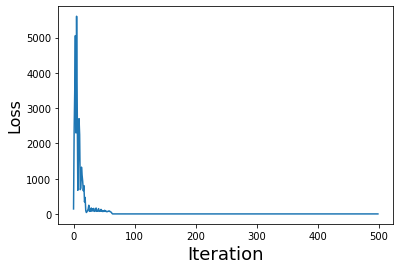

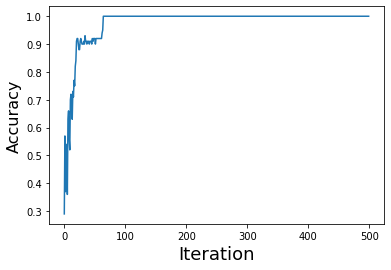

In [ ]:
## Load Q3 Dataset
datapath = './Q3_data.npz'
data = np.load(datapath)

## Load Data and Parse Shape Information
X = data['X']
Y = data['Y']
print(X.shape, Y.shape, np.unique(Y))
nin = X.shape[1]
nout = np.max(Y) + 1

## Initialize data using your Value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

## Initialize a Linear Model
linear_model = LinearLayer(nin, nout)

## Train the Model using Your Data
train(x, y, linear_model)

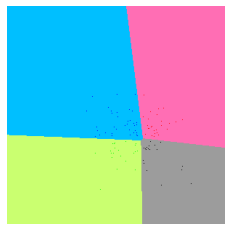

In [ ]:
## Visualize learned decision boundaries
visualization(X, Y, linear_model)

## Question 4

### a) Is this dataset linear separable?
load the dataset for this question and train a linear model on this dataset and report the performance

In [59]:
## Load Q4 Dataset
datapath = './Q4_data.npz'
data = np.load(datapath)

## Parse Data and Identify Dimensions
X = data['X']
Y = data['Y']
nin = X.shape[1] #2
nout = int(np.max(Y)) + 1 #4

## Initialize data using your value class
x = [[Value(v) for v in sample] for sample in X] #40*2
y = [int(v) for v in Y] #40

iteration 19 loss: 64.32016967855027 accuracy: 0.75
iteration 39 loss: 39.07129894408237 accuracy: 0.825
iteration 59 loss: 33.59976269800834 accuracy: 0.875
iteration 79 loss: 114.85316260170485 accuracy: 0.775
iteration 99 loss: 54.21201819231788 accuracy: 0.85
iteration 119 loss: 66.68253379549665 accuracy: 0.8
iteration 139 loss: 55.506599860463574 accuracy: 0.9
iteration 159 loss: 46.921378371421916 accuracy: 0.875
iteration 179 loss: 70.05837759393037 accuracy: 0.7
iteration 199 loss: 53.59870249945797 accuracy: 0.825
iteration 219 loss: 58.680886271335936 accuracy: 0.875
iteration 239 loss: 50.444202197578505 accuracy: 0.9
iteration 259 loss: 97.76436984980984 accuracy: 0.85
iteration 279 loss: 43.51148284704855 accuracy: 0.8
iteration 299 loss: 74.90261587515299 accuracy: 0.75
iteration 319 loss: 48.19441664965033 accuracy: 0.8
iteration 339 loss: 42.03659788585955 accuracy: 0.8
iteration 359 loss: 51.43070047723787 accuracy: 0.8
iteration 379 loss: 96.18315692500246 accuracy: 

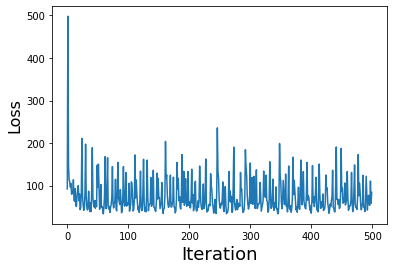

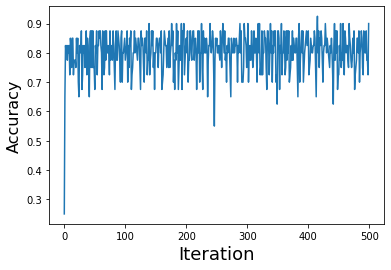

In [60]:
## Initialize Linear Model
linear_model = LinearLayer(nin, nout)

## Train Model
train(x, y, linear_model)

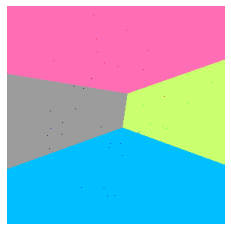

In [61]:
## Visualize Learned Decision Boundary
visualization(X, Y, linear_model)

### b) Implementation of Multi Layer Perceptron (MLP)

Implement a class `MLP` to add arbitrary layers. You will need to implement the forward function to return results `out` with `x` fed into the model.

In [62]:
class MLP(Module):
    
    """
    Multi Layer Perceptron
    """
    def __init__(self, dimensions):
        """
        Initialize multiple layers here in the list named self.linear_layers
        """
        assert isinstance(dimensions, list)
        assert len(dimensions) > 2
        self.linear_layers = []
        for i in range(len(dimensions) - 1):
            self.linear_layers.append(LinearLayer(dimensions[i], dimensions[i+1]))

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]
        
        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO Implement this function and return the output of a MLP
        #return NotImplementedError
        # num of layers: len(self.linear_layers)-1
        # num of rows per layer: self.linear_layers.nin
        # num of cols per layer: self.linear_layers.nout
        xout = x
        for i, layer in enumerate(self.linear_layers):
          xout = layer(xout)
          if i < len(self.linear_layers) - 1:
            xout = np.array([[v.relu() for v in row] for row in xout])
        return xout
  
    def parameters(self):
        """
        Get the parameters of each layer
        
        Args:
            None
        
        Returns:
            params (list of Values): Parameters of the MLP
        """
        return [p for layer in self.linear_layers for p in layer.parameters()]
  
    def zero_grad(self):
        """
        Zero out the gradient of each parameter
        """
        for p in self.parameters():
            p.grad = 0

Train your MLP model and visualize the decision boundary with ground truth points.

iteration 19 loss: 18.285040925042193 accuracy: 0.85
iteration 39 loss: 16.263418420234547 accuracy: 0.825
iteration 59 loss: 15.251651353047853 accuracy: 0.825
iteration 79 loss: 14.532364247307214 accuracy: 0.825
iteration 99 loss: 14.009800609918212 accuracy: 0.875
iteration 119 loss: 13.587374215121958 accuracy: 0.875
iteration 139 loss: 13.246290541504704 accuracy: 0.875
iteration 159 loss: 12.89174239163063 accuracy: 0.875
iteration 179 loss: 12.59001938947722 accuracy: 0.875
iteration 199 loss: 12.33086181252935 accuracy: 0.875
iteration 219 loss: 12.0918702391982 accuracy: 0.9
iteration 239 loss: 11.879124028170414 accuracy: 0.9
iteration 259 loss: 11.632529497045816 accuracy: 0.9
iteration 279 loss: 11.400754344133277 accuracy: 0.9
iteration 299 loss: 11.275988670158899 accuracy: 0.9
iteration 319 loss: 11.16004805123973 accuracy: 0.9
iteration 339 loss: 11.048377180955027 accuracy: 0.9
iteration 359 loss: 10.94463078979013 accuracy: 0.9
iteration 379 loss: 10.84288821732265 a

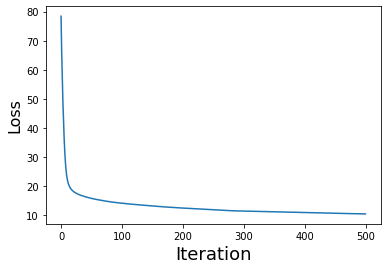

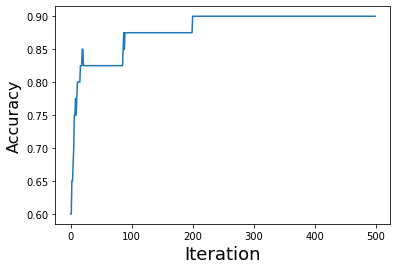

In [63]:
## Initialize MLP with Given Parameters
mlp_model = MLP([nin, 40, nout])

## Train the MLP
train(x, y, mlp_model, learning_rate=1e-3)

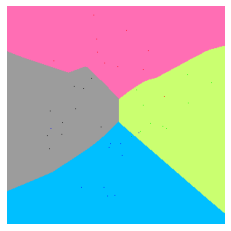

In [64]:
## Visualize Decision Boundaries
visualization(X, Y, mlp_model)

## Acknowledgement

The design of the auto grade structure are based on the work https://github.com/karpathy/micrograd